<a href="https://colab.research.google.com/github/Simurgh818/AutostitchingProject/blob/master/MidtermProject_Fall2022_SinaDabiri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation Mini-Project 

Eva Dyer, BMED 6517

*Segmentation is an important task in many domains. In this assignment, you will build a pixel-level segmentation model to segment brain images into their different underlying components!*

#### 1. Dataset Description

The dataset that we will work with  is contains high-resolution (~1.2 micron) 3D imaging data from a large brain volume spanning multiple brain regions including **Cortex, Striatum, Thalamus (VP) and Zona Incerta (ZI)**. 



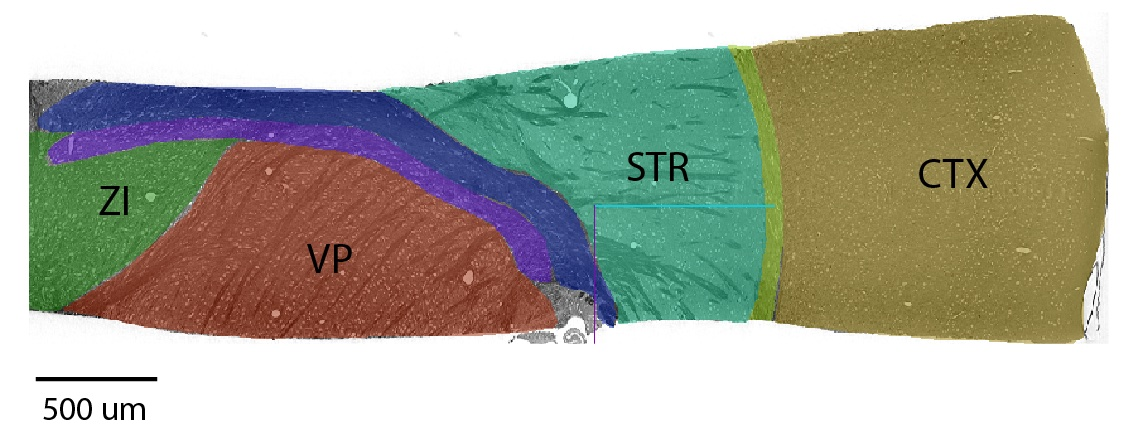

In each of these regions, we have dense annotations of brain structures at the pixel level provided, as well as the brain region of interest (ROI) that it's contained in.

In most of the regions of interest, we can divide the images into four classes. In the 4-class setting, we will classify each pixel as:
- blood vessels
- cell bodies
- axons
- background (other)

However, in some cases, axons are not easy to segment. In this case, we turn our 4-class problem into a 3-class problem where we merge axons with other tissues into a larger background class.  

In the 3-class setting, we will classify each pixel as:
- blood vessels
- cell bodies
- axons, background (other)

In (A) from left to right, we have the original microCT images from Striatum (top row) and Thalamus (bottom) row, and their corresponding ground truth multi-class annotations, and predictions from a tuned 2D U-net model in the 3-class and 4-class setting. In (B), we visualize a small 3D subvolume from Striatum with and without axons.

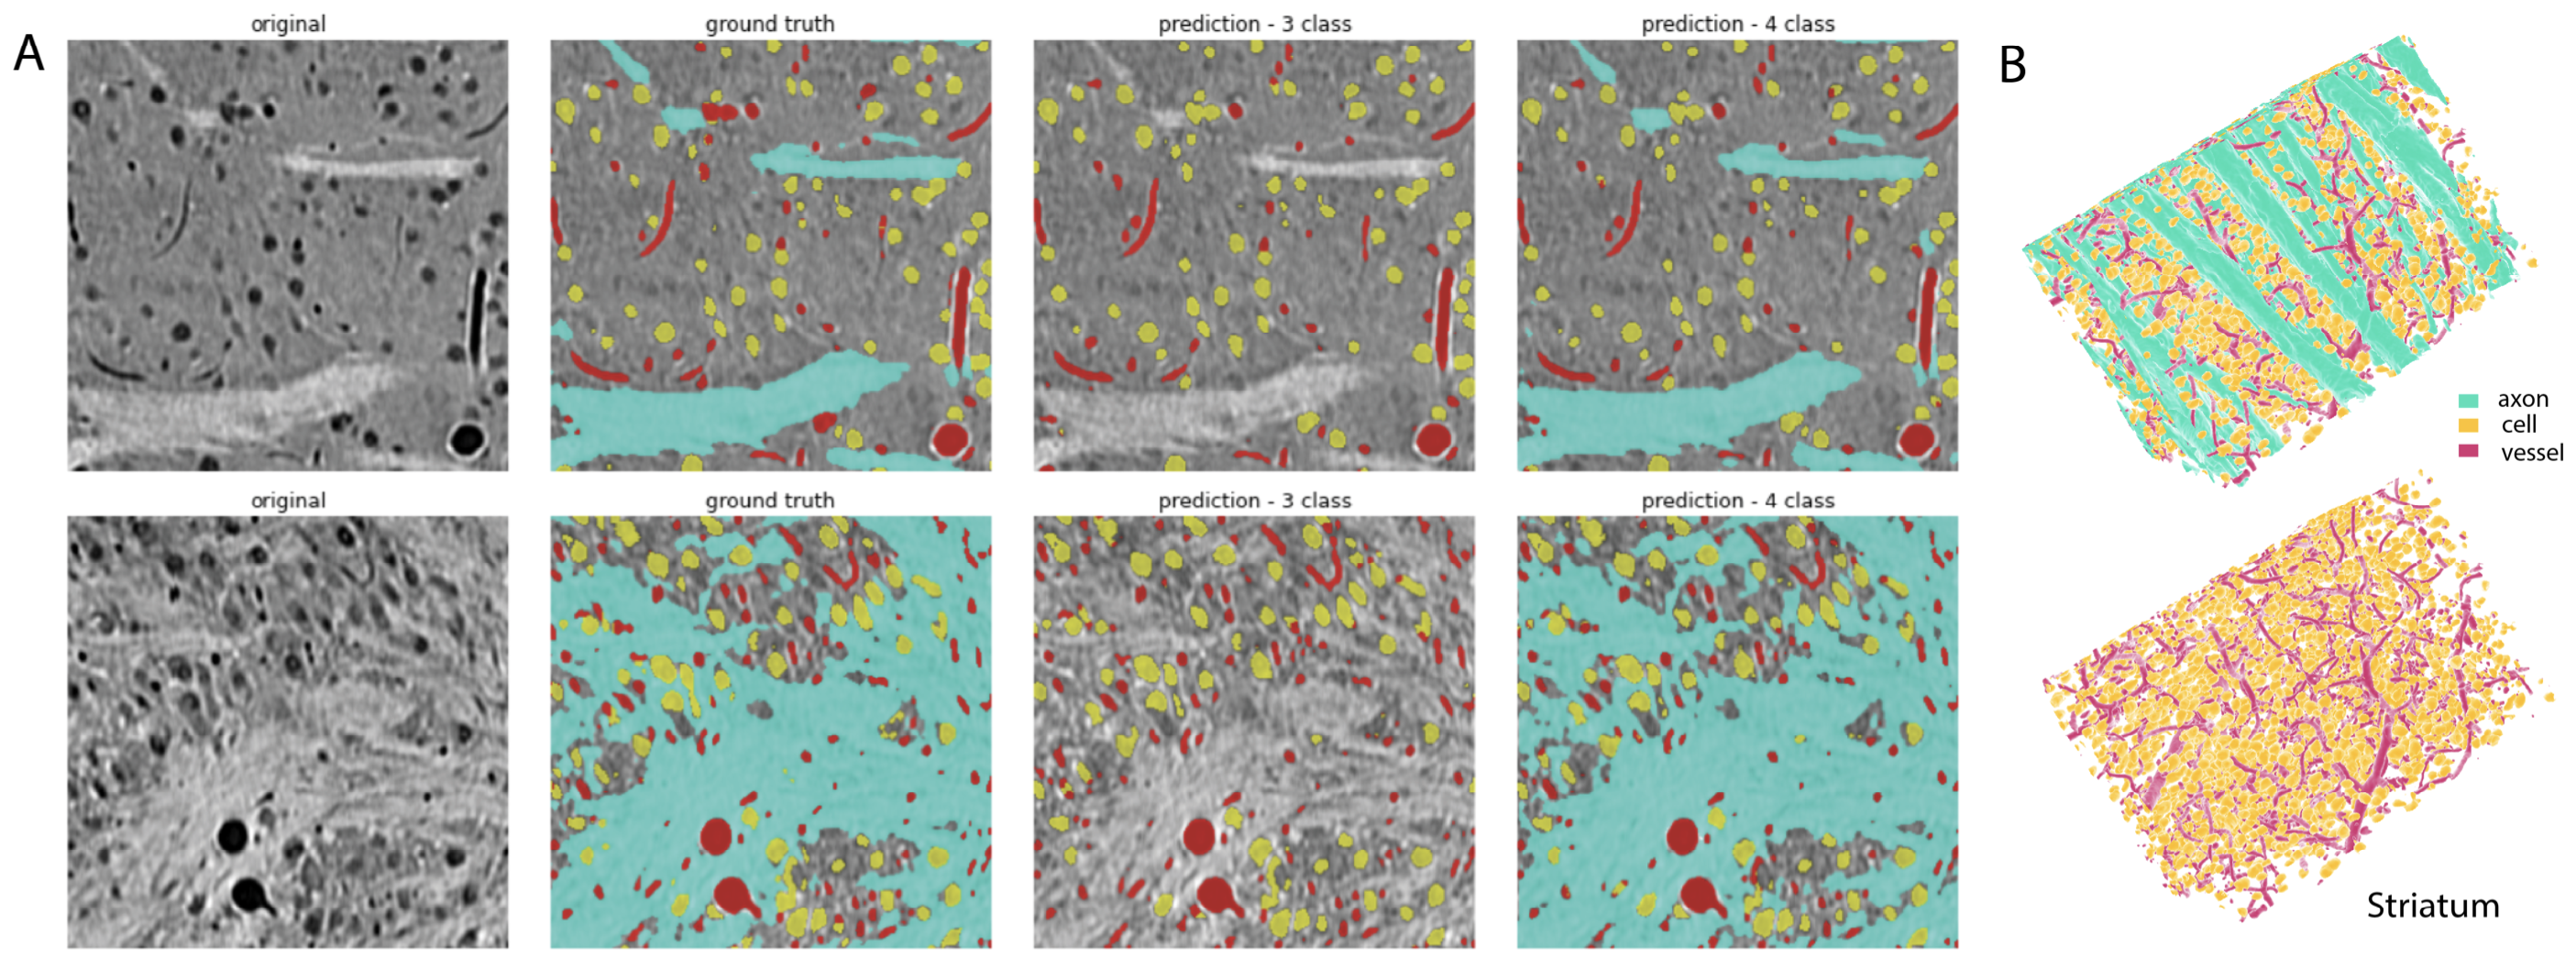

**More information on the dataset and ML tasks**

You can check out the full volumetric dataset at [bossDB](https://bossdb.org/project/prasad2020).

More information on the dataset and how to build multi-scale models of neural structure here:
- [MTNeuro Benchmark](https://sites.gatech.edu/dyerlab/files/2022/10/MTNeuro_Neurips2022.pdf)
- [Multi-task learning for neuroanatomy](https://sites.gatech.edu/dyerlab/files/2022/10/ICIP_2021___XRay_MTL.pdf)
- [Dataset paper](https://www.nature.com/articles/s41597-020-00692-y)

#### 2. Download data and annotations

##### Setup enviornment

In [1]:
#importing MTNeuro benchmark
!wget https://www.dropbox.com/s/op7av8nso0sq85q/cloudvolume-requirements.txt -q --show-progress --progress=dot
!pip install -r cloudvolume-requirements.txt
!git clone https://github.com/MTNeuro/MTNeuro

!pip install scikit-learn
!pip install intern

#installing dependencies
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet_pytorch

#importing segmentation_models.pytorch library
!pip install github-clone
!ghclone https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch 
!cp -rf segmentation_models_pytorch MTNeuro/MTNeuro/.
!rm -rf segmentation_models_pytorch


     0K ....                                                  100%  559M=0sLooking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 4.4 MB/s 
     |████████████████████████████████| 9.1 MB 40.7 MB/s 
     |████████████████████████████████| 357 kB 68.1 MB/s 
     |████████████████████████████████| 160 kB 71.6 MB/s 
     |████████████████████████████████| 48 kB 5.9 MB/s 
     |████████████████████████████████| 217 kB 70.4 MB/s 
     |████████████████████████████████| 908 kB 69.8 MB/s 
     |████████████████████████████████| 2.1 MB 25.6 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 4.1 MB 22.1 MB/s 
     |████████████████████████████████| 168 kB 73.8 MB/s 
     |████████████████████████████████| 4.4 MB 39.3 MB/s 
     |████████████████████████████████| 4.2 MB 42.1 MB/s 
     |████████████████████████████████| 903 kB 54.2 MB/s 
     |████████████

Cloning into 'MTNeuro'...
remote: Enumerating objects: 847, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 847 (delta 123), reused 166 (delta 86), pack-reused 617
Receiving objects: 100% (847/847), 17.92 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (395/395), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 854 kB 4.3 MB/s 
     |████████████████████████████████| 2.6 MB 46.5 MB/s 
     |████████████████████████████████| 152 kB 30.0 MB/s 
  Created wheel for intern: filename=intern-1.3.3-py2.py3-none-any.whl size=149160 sha256=676d6d3c98820b57206a900c8ae75f5a3c0750c2cce169229b15b9a84eea4d62
  Stored in directory: /root/.cache/pip/wheels/ff/06/42/dbdd15ce62b156b39b1fdd63def0efcaabdbc58c84eae1bd81
Successfully built intern


##### Data access through BossDB

In [2]:
#import libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
import json as json
import glob as glob
import seaborn as sns
from tqdm import tqdm
from intern import array

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor

#setting the location to look for the required packages
sys.path.append('MTNeuro/MTNeuro/')
#BossDB library and MTNeuro dataset loader
from bossdbdataset import BossDBDataset  
             
from models.unet import UNet                   #UNet model. From: https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial
import segmentation_models_pytorch as smp      #SMP library (used for calculation of performance metrics: https://github.com/qubvel/segmentation_models.pytorch


#set random seed
np.random.seed(0)

**Using Boss to download data cutouts**

The Brain Observatory Storage Service (BOSS) provides access to a variety of volumetric datasets from the brain. Below we provide an example call to pull down a cutout of data and their labels.

In [3]:
example_config = {
    "name": "example",
    "image_chan": "bossdb://prasad/prasad2020/image", 
    "annotation_chan": "bossdb://prasad/prasad_analysis/roi_labels",

    # X and Y range of the cortex (256 x 256)
    "xrange_cor": [4600,4856],
    "yrange_cor": [900,1156],

    # X and Y range of the striatum (256 x 256)
    "xrange_stri": [3700,3956],
    "yrange_stri": [500,756],

    # X and Y range of the thalamus (0 x 0)
    "xrange_vp": [3063,3319],
    "yrange_vp": [850,1106],

    # X and Y range of the zona incerta (0 x 0)
    "xrange_zi": [1543,1799],
    "yrange_zi": [650,906],

    # Z range for training and validation
    # This will pull from all brain regions
    "z_train": [110, 120],  #  full z_train range: [110, 379]
    "z_val": [400, 420], # full z_val range: [380, 409]
    "volume_z": 1,

    "tile_size": [256,256],
}

In [4]:
transform = transforms.Compose([transforms.ToTensor(),])

train_data = BossDBDataset(example_config, None, 'train', image_transform = transform, mask_transform = transform)
test_data = BossDBDataset(example_config, None, 'val',  image_transform = transform, mask_transform = transform)

train_dataloader = DataLoader(dataset=train_data, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, shuffle=False)
# training or validation slices are concatenated across each brain region: 
# cortex, striatum, thalamus, zona incerta

print("train_data contains", len(train_data), "slices")
print("test_data contains", len(test_data), "slices")

/usr/local/lib/python3.7/dist-packages/intern/convenience/array.py:449: ImportWarning: CloudVolume is not installed. Accessing channel using CVDB.
  warnings.warn("CloudVolume is not installed. Accessing channel using CVDB.", ImportWarning)


train_data contains 40 slices
test_data contains 80 slices


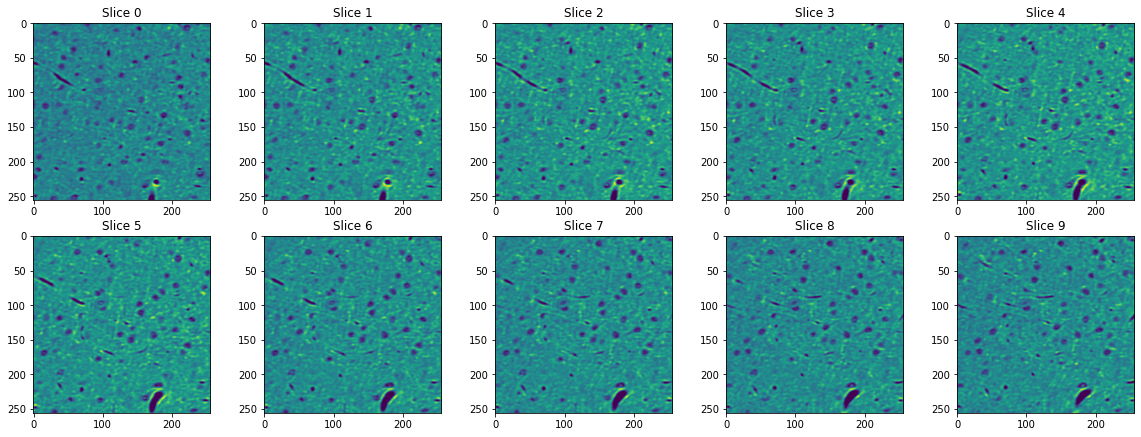

In [5]:
cortex_indices = np.arange(0, 10)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(20)
for i, (x,y) in enumerate(train_dataloader):
  if i in cortex_indices:
    plt.subplot(4, 5, 1+i)
    plt.imshow(x.squeeze())
    plt.title("Slice " + str(i))

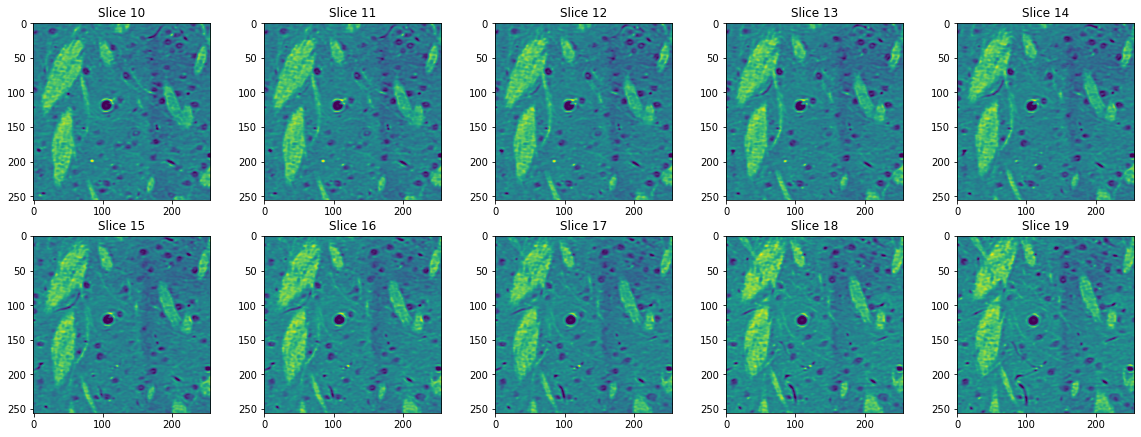

In [6]:
striatum_indices = np.arange(10, 20)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(20)
for i, (x,y) in enumerate(train_dataloader):
  if i in striatum_indices:
    plt.subplot(4, 5, 1+i)
    plt.imshow(x.squeeze())
    plt.title("Slice " + str(i))

In [7]:
# print(np.shape(train_dataloader))
# x,y = enumerate(train_dataloader)
cortex_idx = np.arange(0,1)
striatum_idx = np.arange(10,11)
# x = train_data[cortex_idx]
# print(np.shape(x))

torch.Size([256, 256])
The first Quartile is:  0.3803921639919281
The first Quartile is:  0.38823530077934265


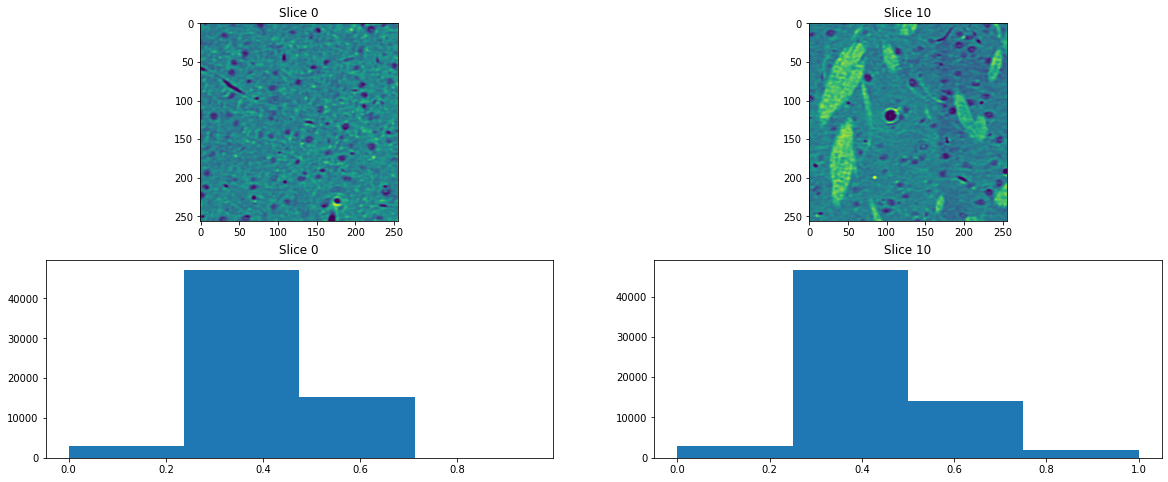

In [52]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(20)
for i, (x,y) in enumerate(train_dataloader):
  if i in cortex_idx:
    plt.subplot(2, 2, 1)
    cortex_x = x.squeeze()
    plt.imshow(cortex_x)
    plt.title("Slice " + str(i))
    plt.subplot(2, 2, 3)
    plt.hist(cortex_x.numpy().ravel(), bins=4)
    plt.title("Slice " + str(i))
    print(np.shape(cortex_x))
    first_qrt = np.quantile(cortex_x,0.25)
    print("The first Quartile is: ", first_qrt)

  if i in striatum_idx:
    plt.subplot(2, 2, 2)
    striatum_x = x.squeeze()
    plt.imshow(striatum_x)
    plt.title("Slice " + str(i))
    plt.subplot(2, 2, 4)
    plt.hist(striatum_x.numpy().ravel(), bins=4)
    plt.title("Slice " + str(i))
    first_qrt = np.quantile(striatum_x,0.25)
    print("The first Quartile is: ", first_qrt)


In [15]:
cortex_x_np = cortex_x.numpy()
striatum_x_np = striatum_x.numpy()
print(np.shape(cortex_x_np))


(256, 256)


In [18]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import cv2

(array([ 3291.,     0.,     0., 62245.]),
 array([0.   , 0.095, 0.19 , 0.285, 0.38 ], dtype=float32),
 <a list of 4 Patch objects>)

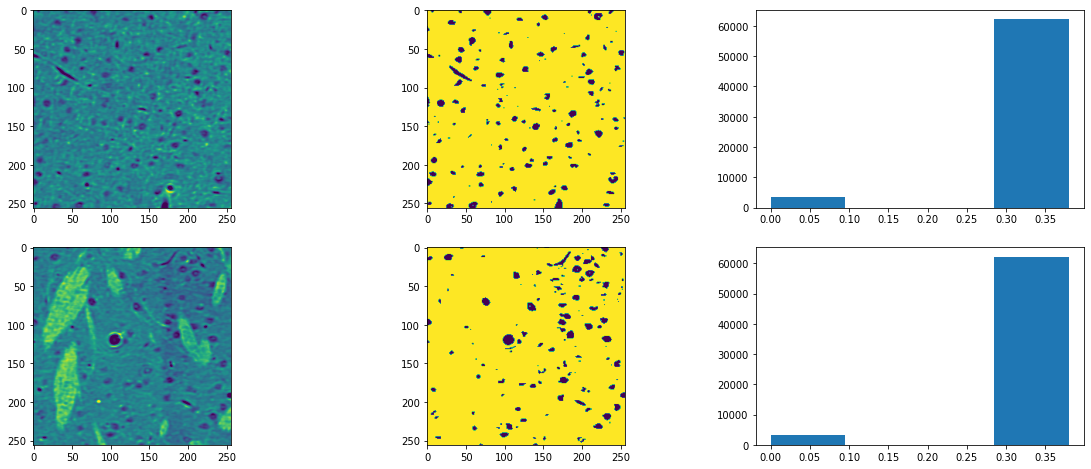

In [105]:
ret, cortex_thresh = cv2.threshold(cortex_x_np, 0.26, 0.38, cv2.THRESH_BINARY)
ret, striatum_thresh = cv2.threshold(striatum_x_np, 0.26, 0.38, cv2.THRESH_BINARY)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(20)
plt.subplot(2, 3, 1)
plt.imshow(cortex_x_np)
plt.subplot(2, 3, 2)
plt.imshow(cortex_thresh);
plt.subplot(2,3,3)
plt.hist(cortex_thresh.ravel(), bins=4)
plt.subplot(2, 3, 4)
plt.imshow(striatum_x_np)
plt.subplot(2, 3, 5)
plt.imshow(striatum_thresh);
plt.subplot(2,3,6)
plt.hist(striatum_thresh.ravel(), bins=4)

In [106]:
cortex_thresh_ravel = np.array(cortex_thresh).reshape(-1,1)
print(np.shape(cortex_thresh_ravel))

(65536, 1)


#### MTNeuro Benchmark 

We will use the MTNeuro benchmark (https://mtneuro.github.io) training and validation image segmentation datasets for this project.

In [82]:
## Load the task config for 2D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config_4class = json.load(open('MTNeuro/MTNeuro/taskconfig/task2_2D_4class.json'))
task_config_4class

{'name': 'task2_2D_4class',
 'image_chan': 'bossdb://prasad/prasad2020/image',
 'annotation_chan': 'bossdb://prasad/prasad_analysis/pixel_labels',
 'xrange_cor': [4600, 4856],
 'yrange_cor': [900, 1156],
 'zrange': [110, 471],
 'xrange_stri': [3700, 3956],
 'yrange_stri': [500, 756],
 'xrange_vp': [3063, 3319],
 'yrange_vp': [850, 1106],
 'xrange_zi': [1543, 1799],
 'yrange_zi': [650, 906],
 'z_train': [110, 379],
 'z_val': [380, 409],
 'z_test': [420, 470],
 'volume_z': 1,
 'tile_size': [256, 256],
 'task_type': 'noZI',
 'combine_ax_and_bg': 0,
 'noZI': 1}

In [83]:
## Load the task config for 2D 3-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config_3class = json.load(open('MTNeuro/MTNeuro/taskconfig/task2_2D_3class.json'))
task_config_3class

{'name': 'task2_2D_3class',
 'image_chan': 'bossdb://prasad/prasad2020/image',
 'annotation_chan': 'bossdb://prasad/prasad_analysis/pixel_labels',
 'xrange_cor': [4600, 4856],
 'yrange_cor': [900, 1156],
 'zrange': [110, 471],
 'xrange_stri': [3700, 3956],
 'yrange_stri': [500, 756],
 'xrange_vp': [3063, 3319],
 'yrange_vp': [850, 1106],
 'xrange_zi': [1543, 1799],
 'yrange_zi': [650, 906],
 'z_train': [110, 379],
 'z_val': [380, 409],
 'z_test': [420, 470],
 'volume_z': 1,
 'tile_size': [256, 256],
 'task_type': '3class',
 'combine_ax_and_bg': 1,
 'noZI': 0}

In [84]:
####Specify the required transforms and load the data for task 2
transform = transforms.Compose([transforms.ToTensor(),])   #Just converts to each element to tensor. Equivalent to no transform applied. 

##Set-up the train dataloader and validation dataloader for 4-class
task_config = task_config_4class
train_data = BossDBDataset(task_config, None, 'train', image_transform = transform, mask_transform = transform)
val_data = BossDBDataset(task_config, None, 'val',  image_transform = transform, mask_transform = transform)
test_data = BossDBDataset(task_config, None, 'test',  image_transform = transform, mask_transform = transform)

label_names = ["BG", "cell", "BV", "axon"]

/usr/local/lib/python3.7/dist-packages/intern/convenience/array.py:449: ImportWarning: CloudVolume is not installed. Accessing channel using CVDB.
  warnings.warn("CloudVolume is not installed. Accessing channel using CVDB.", ImportWarning)


In [85]:
# Utility function for plotting
def plot_slice(dataset, index, prediction=None):
  """Plots (input, label) or (input, label, prediction) images
  dataset: the dataset to draw the slice from
  index: index of the slice
  prediction: predicted annotation of the slice [optional]
  """
  index = [index] if type(index) is int else index
  p = prediction is not None
  l = len(index)

  fig = plt.figure()
  fig.set_figheight(5*l)
  fig.set_figwidth(10+5*p)

  for i, j in enumerate(index):
    x, y = dataset[j]

    plt.subplot(l,2+p,1+(2+p)*i)
    plt.imshow(x.squeeze())
    plt.title("Slice " + str(j))
    plt.subplot(l,2+p,2+(2+p)*i)
    plt.imshow(y.squeeze(), vmin=0, vmax=3)
    plt.title("Groundtruth Annotation")
    if p:
      plt.subplot(l,2+p,3+3*i)
      plt.imshow(prediction[i].squeeze(), vmin=0, vmax=3)
      plt.title("Predicted Annotation")

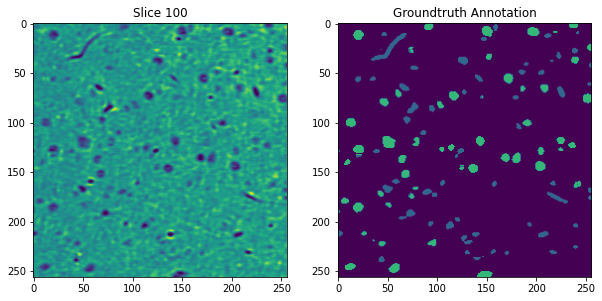

In [86]:
# Plot different slices in the dataset
plot_slice(train_data, 100)

#### 3. Feature Extraction

We will now step through a simple workflow for feature extraction that consists of two steps. 
- (Step 1) filter images with different pre-defined kernels
- (Step 2) extract mean and std of filtered output over a small local window in the filtered output.

In [87]:
# Feature extraction functions
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.signal import convolve2d
from sklearn.preprocessing import StandardScaler

In [88]:
def plot_figures_filters(img0, filt, filt_img0, filt_img0_padded):
  """Plots the original image, filter, and filtered image
  """
  f = plt.figure()
  f.set_figheight(10)
  f.set_figwidth(15)

  plt.subplot(131)
  plt.title('Original image')
  plt.imshow(img0)
  plt.xticks([])
  plt.yticks([])

  plt.subplot(132)
  plt.title('Filter')
  plt.imshow(filt)
  plt.xticks([])
  plt.yticks([])
  
  plt.subplot(133)
  plt.title('Filtered image')
  plt.imshow(filt_img0)
  plt.xticks([])
  plt.yticks([])

In [121]:
def compute_filter_feats(img0, k, filt):
  """
  img0: input image
  k: patch size (dimensions of patch: (k,k))
  filt: filter to convolve image with (e.g., 3x3)
  returns: mean of filter, 
  """

  # Convolution
  filt_img0 = convolve2d(img0, filt, mode='same')
  
  # Padding
  if k%2 == 1:
      p = int((k-1)/2)
      padding=((p,p),(p,p))
  if k%2 == 0:
      p = int((k-2)/2)
      padding=((p,p+1),(p,p+1))

  filt_img0_padded = np.pad(filt_img0, padding, 'constant', constant_values=((0,0),(0,0))) # apply padding to image
  patches_filt_img0 = extract_patches_2d(filt_img0_padded, (k,k), random_state=22) # padded patches of image
  
  print(np.shape(patches_filt_img0))
  #### COMPUTE DIFFERENT FEATURES HERE
  # Calculate mean and std for each patch of the filtered image
  mean_filt_img0 = np.array([np.mean(patches_filt_img0[ind]) for ind in range(len(patches_filt_img0))]).reshape(-1,1)
  std_filt_img0 = np.array([np.std(patches_filt_img0[ind]) for ind in range(len(patches_filt_img0))]).reshape(-1,1)
  
  # 1st quantile features
  firstQuan_filt_img0 = np.array([np.quantile(patches_filt_img0[ind], 0.25) for ind in range(len(patches_filt_img0))]).reshape(-1,1)

  # Thresholding for cells
  patches_filt_img0_np = patches_filt_img0.numpy()
  ret, thresh_filt_img0 = cv2.threshold(patches_filt_img0_np, 0.26, 0.38, cv2.THRESH_BINARY)
  thresh_filt_img0_ravel = np.array(thresh_filt_img0).reshape(-1,1)

  feats_filt_img0 = np.hstack((mean_filt_img0, std_filt_img0, firstQuan_filt_img0, thresh_filt_img0_ravel))
  
  # Figure of filters
  # (comment the following line out if you don't want the plots to show)
  # plot_figures_filters(img0, filt, filt_img0, filt_img0_padded)

  return feats_filt_img0

#### 3.1: Feature Extraction: 
- 

In [122]:
# FEATURE EXTRACTION
# Change/add new features here (!!!)

num_feats = 4

def extract_features(x):
  patch_sz = 3
  x = x.squeeze()

  # Empty feature list
  x_feats = []

  # Example feature 1: Square raw pixel values
  x_feats.append((x.flatten() ** 2)[:, np.newaxis])

  # Example feature 2 and 3: Identity kernel features (mean and standard deviation)
  patch_size = 3
  filt_I = np.array([[0,0,0],
                     [0,1,0],
                     [0,0,0]]) # 3x3 identity kernel

  # add a circular kernel for cell, an elliptical one for BV

  x_feats.append(compute_filter_feats(x, patch_sz, filt_I))

  # Return computed features
  return np.hstack(x_feats)

In [123]:
num_train = len(train_data)
num_val = len(val_data)
print("Number of training samples =", num_train)
print("Number of validation samples =", num_val)

Number of training samples = 807
Number of validation samples = 87


In [124]:
# Slices in the train/val dataset to train on
# You can change the indices here, but don't put in too many
train_index = [100, 200, 300, 400, 500]
val_index = [25, 50, 75]

# plot_slice(train_data, train_index)
# plot_slice(val_data, val_index)

In [ ]:
# Calculating train set features
x_train_feats, y_train = [], []
for idx in train_index:
  x, y = train_data[idx]
  # Extract features and flatten labels
  x_train_feats.append(extract_features(x)) # calling the extract_features function where x is train_data image
  # The extract_features(x) calls compute_filter_feats(x, patch_sz, filt_I), where filt_I is a 3x3 identity kernel
  y_train.append(y.ravel())
x_train_feats = np.vstack(x_train_feats)
y_train = np.concatenate(y_train)

(65536, 3, 3)


In [126]:
# Calculating val set features
x_val_feats, y_val = [], []
for idx in val_index:
  x, y = val_data[idx]
  # Extract features and flatten labels
  x_val_feats.append(extract_features(x))
  y_val.append(y.ravel())
x_val_feats = np.vstack(x_val_feats)
y_val = np.concatenate(y_val)

(65536, 3, 3)


AttributeError: ignored

In [ ]:
# Standardize featuers
scaler = StandardScaler()
x_train_feats = scaler.fit_transform(x_train_feats)
x_val_feats = scaler.fit_transform(x_val_feats)

In [ ]:
print("x_train_feats: ", x_train_feats, np.shape(x_train_feats))

#### 4. Create your classification model

In [ ]:
# Model
from sklearn import linear_model

# Evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [109]:
clf = linear_model.LogisticRegression()
clf.fit(x_train_feats, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

              precision    recall  f1-score   support

          BG       0.79      0.99      0.88    127148
        cell       0.70      0.27      0.39      6445
          BV       0.69      0.70      0.69     11537
        axon       0.95      0.44      0.60     51478

    accuracy                           0.80    196608
   macro avg       0.78      0.60      0.64    196608
weighted avg       0.82      0.80      0.78    196608



([<matplotlib.axis.YTick at 0x7f566bd14a90>,
 [Text(0, 0.5, 'BG'),
  Text(0, 1.5, 'cell'),
  Text(0, 2.5, 'BV'),
  Text(0, 3.5, 'axon')])

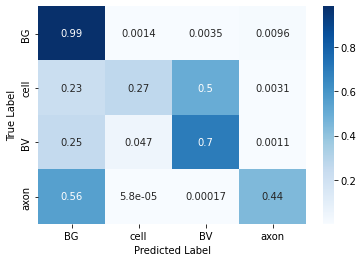

In [110]:
# Predict pixel annotations
y_train_predict_flat = clf.predict(x_train_feats)
y_val_predict_flat = clf.predict(x_val_feats)

# Report of results (table)
test_class_report = classification_report(y_val, y_val_predict_flat, target_names=label_names)
print(test_class_report)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_predict_flat, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5,1.5,2.5,3.5], label_names)
plt.yticks([0.5,1.5,2.5,3.5], label_names)

In [111]:
def flat_to_img(imgs, shape=(256, 256)):
  """Converts a flattened image back to a 2D image
  """
  num_pixels = shape[0]*shape[1]
  n = imgs.size // num_pixels
  imgs_2d = []
  for i in range(n):
    imgs_2d += [np.reshape(imgs[i*num_pixels:(i+1)*num_pixels], shape)]
  return np.array(imgs_2d)

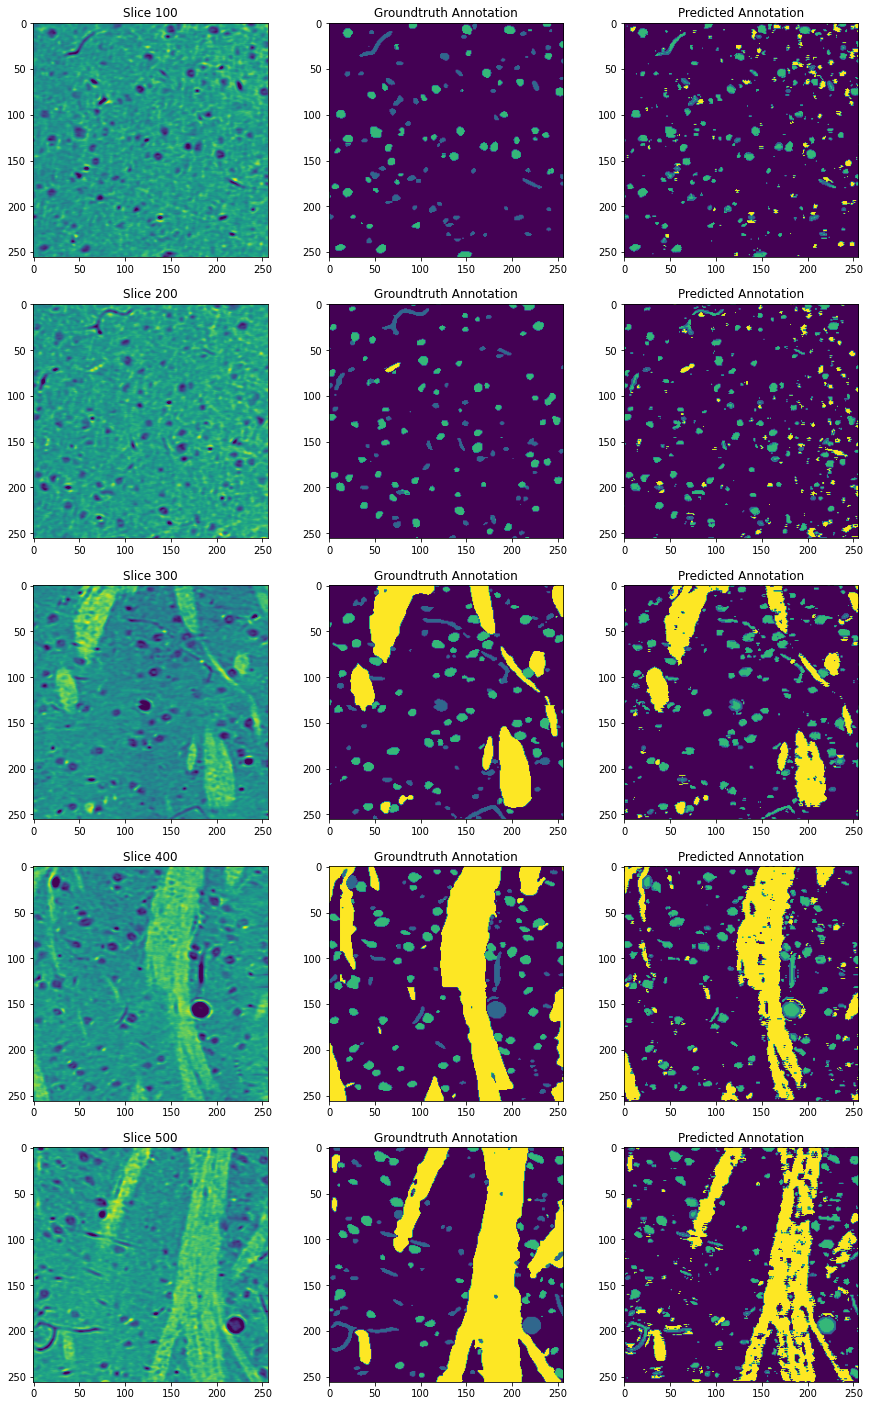

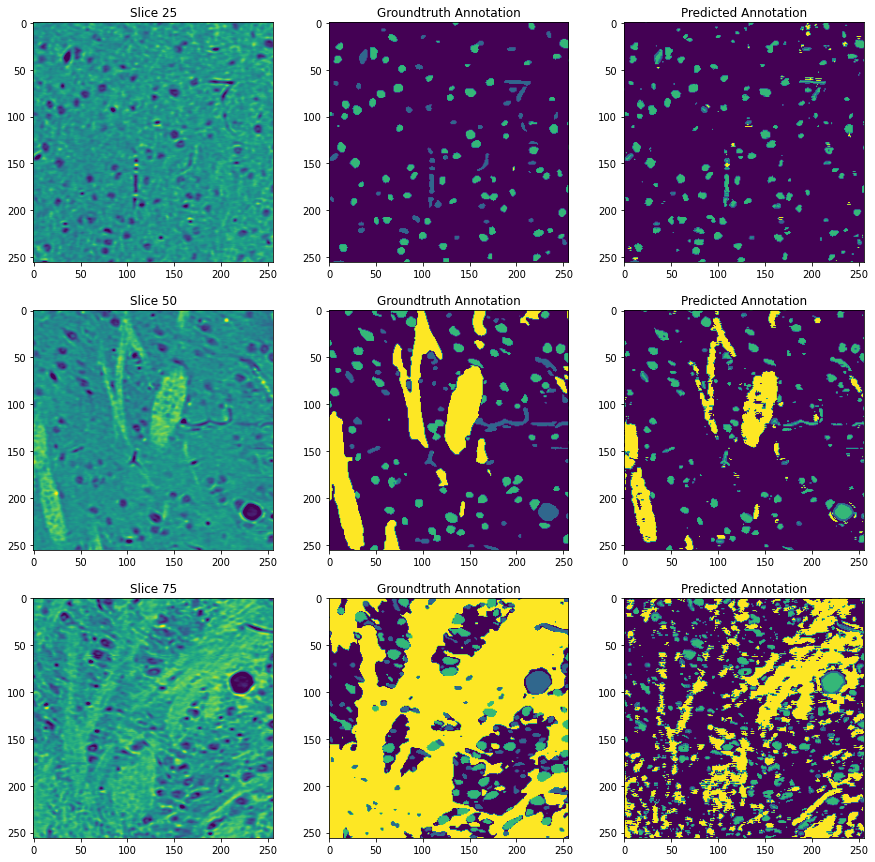

In [112]:
y_train_predict = flat_to_img(y_train_predict_flat)
y_val_predict = flat_to_img(y_val_predict_flat)

plot_slice(train_data, train_index, prediction=y_train_predict)
plot_slice(val_data, val_index, prediction=y_val_predict)

### **Mini-project: Image Segmentation**

Your goal is to build a pixel-level segmentation model that has improved accuracy and good generalization across different brain regions. You can either choose the 3-class or the 4-class condition.

#### 1. Training your model:

- Your model can be trained with any slice(s) in the training dataset. Training with all of the slices may significantly increase the training time. In this case, subsampling pixels (or computed features) across slices could be an alternative strategy for training.

- You can use many different tools or approaches for this task. Some examples include: 
  - Changing and adding filters you use to train the classifier, 
  - Modifying the classification method
  - Subsampling or augmenting the training dataset
  - Using morphological filtering operations to post process your classifier outputs.

#### 2. Testing your model:  
After using your training and validation datasets to build a model, you will then need to test your model on the MTNeuro test set. In the MTNeuro data loaders, the training slices are defined as follows: "z_train": [110, 379], "z_val": [380, 409], and "z_test": [420, 470].

Describe your method for hyperparameter optimization and model fitting and summarize your accuracies on the test set (overall) and split your accuracies and metrics across classes as well.

#### 3. Reporting your results:

After developing your new model, you will write up a short summary of your results and methods (4-5 pages including visuals). 

In your report, please include the following:
- **Explanation of your method**. 
  - How did you solve the challenge and what approach did you use? What does are the inputs, features, and what are the outputs? 
  - Provide a block diagram outlining your overall approach for semantic segmentation
- **Model fitting and hyperparameter optimization**. 
  - Explain your model fitting approach and describe how you optimized the hyperparameters in your model. 
- **Quantify the performance and compare with other models**. 
  - Include the precision, recall and F1 score, and per-class accuracy for your model on the training, validation and test set. You can add more metrics (and report on other slices) if you'd like!
  - Include a visualization with different models and hyperparameters to show how robust your model is across different parameters tested. Include the simple baseline provided in this notebook as a comparison point.
  - Include relevant figures that summarize your data, results, and how different steps in the method may have contributed to the overall outcomes.
- **Conclusions.** How did you go about achieving improvements over the baseline provided? What worked and what didn't? Describe lessons learned and potential next steps that you would try if you had more time.

_____________________

#### Additional Example - Pulling down Region of Interest Labels

In [ ]:
## Let's get and plot the regions of interest in this task2 dataset
roi_config = task_config.copy()

roi_config["name"] = "task1"
roi_config["annotation_chan"] = "bossdb://prasad/prasad_analysis/roi_labels"

transform = transforms.Compose([transforms.ToTensor(),])
train_roi = BossDBDataset(roi_config, None, 'train',  image_transform = transform, mask_transform = transform)
val_roi = BossDBDataset(roi_config, None, 'val', image_transform = transform, mask_transform = transform)


/usr/local/lib/python3.7/dist-packages/intern/convenience/array.py:449: ImportWarning: CloudVolume is not installed. Accessing channel using CVDB.
  warnings.warn("CloudVolume is not installed. Accessing channel using CVDB.", ImportWarning)


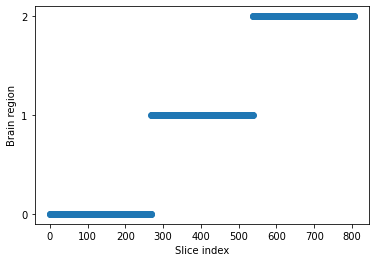

In [ ]:
train_roi_labels = []
for i, (x, y) in enumerate(train_roi):
  train_roi_labels.append(y)

  plt.xlabel("Slice index")
plt.ylabel("Brain region")
plt.yticks(np.arange(min(train_roi_labels), max(train_roi_labels)+1, 1))
plt.scatter(np.arange(0, len(train_roi_labels)), train_roi_labels)

### Resources for training deep learning models

- **Task 2 - Getting started:** https://github.com/MTNeuro/MTNeuro/blob/main/notebooks/task2_getting_started.ipynb

- **Task 2 - Using a pre-trained model:** https://github.com/MTNeuro/MTNeuro/blob/main/notebooks/task2_getting_started.ipynb

